# Классификация автомобилей по их фото¶


Опробована предобученная сеть EfficientNetB7.

In [81]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [82]:
pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-ypqmin6i
Note: you may need to restart the kernel to use updated packages.


### Импорт библиотек

In [83]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.17.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


### Основные настройки

In [85]:
EPOCHS               = 5  # количество эпох на обучение
BATCH_SIZE           = 4 # batch - требует уменьшения, если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4 # скорость обучения
VAL_SPLIT            = 0.15 # объем тестовых данных - 15%
CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (384, 512, IMG_CHANNELS)

In [86]:
DATA_PATH = '/kaggle/input/sf-dl-car-classification/'
PATH = "/kaggle/working/car/"

In [87]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [88]:
train_df = pd.read_csv(DATA_PATH+"train.csv")

In [89]:
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")

In [90]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH + data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


## Подготовка данных

### Аугментация данных

In [91]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(384, 512)
])



In [92]:
train_datagen = ImageDataAugmentor(augment = AUGMENTATIONS,
                                   validation_split=VAL_SPLIT)
        
test_datagen = ImageDataAugmentor()

### Генерация данных

Заворачиваем данные в генератор:

In [93]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с фото 
    target_size=(384, 512),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(384, 512),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(384, 512),
    batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Для сабмита мы используем другой источник test_datagen.flow_from_dataframe, так как нам нужно дать предсказание с привязкой к конкретному Id картинки из dataframe.

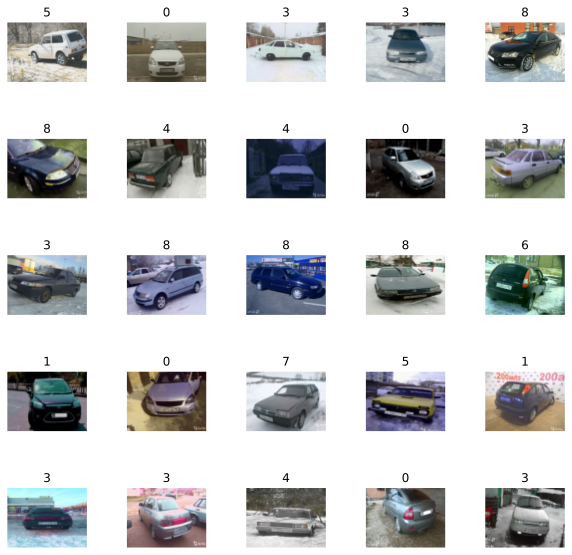

In [94]:
train_generator.show_data()

## Построение модели

### Загрузка предобученной сети EfficientNetB7

In [95]:
base_model = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)

### Установка новой "головы"

In [96]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D())
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [97]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 12, 16, 2560)      64097687  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2560)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               655616    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 64,756,897
Trainable params: 64,445,658
Non-trainable params: 311,239
____________________________________

In [98]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

### Обучение модели

Добавим ModelCheckpoint. Эта функция позволяет сохранять прогресс обучения модели, чтобы в нужный момент можно было его подгрузить и дообучить модель.

In [99]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

Обучение:

In [100]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
3308/3308 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.7618
Epoch 00001: saving model to best_model.hdf5
3308/3308 [==============================] - 2322s 702ms/step - loss: 0.7444 - accuracy: 0.7618 - val_loss: 0.2407 - val_accuracy: 0.9283
Epoch 2/5
3308/3308 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8883
Epoch 00002: saving model to best_model.hdf5
3308/3308 [==============================] - 2318s 701ms/step - loss: 0.3610 - accuracy: 0.8883 - val_loss: 0.1529 - val_accuracy: 0.9644
Epoch 3/5
3308/3308 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.9169
Epoch 00003: saving model to best_model.hdf5
3308/3308 [==============================] - 2317s 700ms/step - loss: 0.2753 - accuracy: 0.9169 - val_loss: 0.1641 - val_accuracy: 0.9592
Epoch 4/5
3308/3308 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9240
Epoch 00004: saving model to best_model.hdf5
3308/3308 [=======

Сохранение итоговой сети и подгрузка лучшей итерации в обучении (best_model):

In [101]:
model.save('/kaggle/working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [102]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 75s 129ms/step - loss: 0.1563 - accuracy: 0.9678
Accuracy: 96.78%


Точность модели составила 96,78 %. 

### Графики обучения

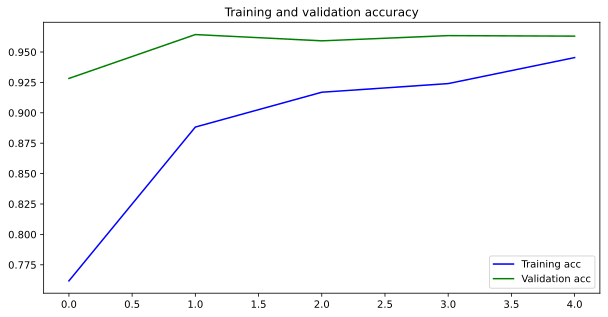

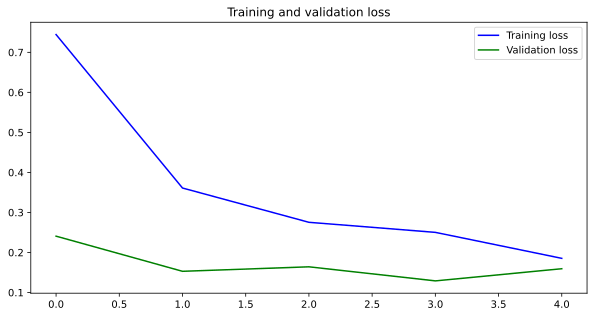

In [103]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

## Предсказание на тестовых данных

In [104]:
test_sub_generator.samples

6675

In [105]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

1669/1669 [==============================] - 202s 121ms/step


In [106]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [107]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


Результат на kaggle улучшился - 0.96659.